# Обучение эмбеддингов (Metric Learning)

## Переключение версии TensorFlow

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'lfw',
     split=['train[:90%]', 
            'train[90%:]'],    
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

## Визуализация датасета LFW

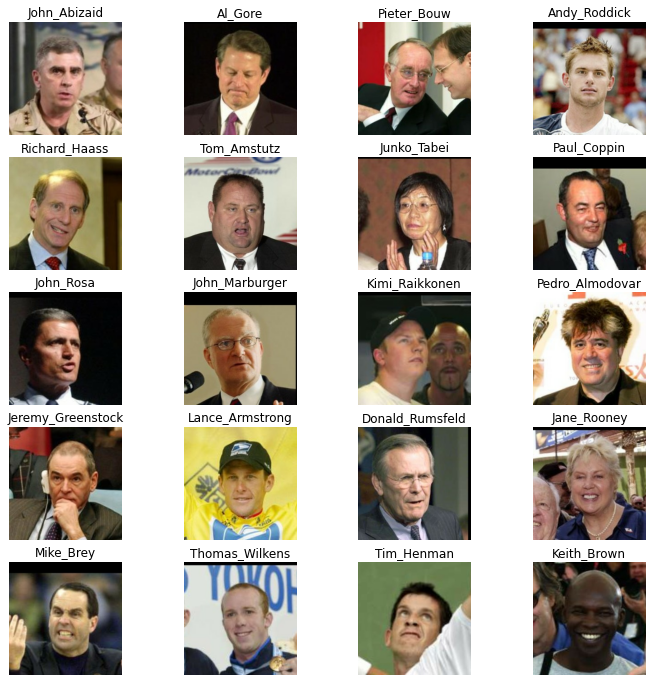

In [3]:
plt.figure(figsize=(12, 12))
for i, x in enumerate(ds_train.take(20)):
    plt.subplot(5, 4, i+1)
    plt.title(x[0].numpy().decode('utf-8'))
    plt.imshow(x[1])
    plt.axis('off')

## Подготовка данных

In [5]:
INP_SIZE = 128
BATCH_SIZE = 128
EPOCHS = 33

def prepare_images(label, img):
    img = tf.cast(img, tf.float32) / 255.
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    return img, label

ds_train = ds_train.map(prepare_images)
ds_train = ds_train.repeat(EPOCHS)
ds_train = ds_train.batch(BATCH_SIZE)

ds_test = ds_test.map(prepare_images)
ds_test = ds_test.batch(BATCH_SIZE)

## Создание модели CNN

In [6]:
EMB_SIZE = 128

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [7]:
MARGIN = 10.0

def contrastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка к обучению

In [8]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [9]:
%%time

for iteration, (images, labels) in enumerate(ds_train):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contrastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))
    if loss_value.numpy() == 0.:
        break

[0] Loss: 91.18597412109375
Wall time: 43.5 s


## Получение эмбеддингов для тестовой выборки

In [10]:
test_labels = []
for i, x in enumerate(ds_test.take(len(ds_test))):
    if i ==0:
        test_images = x[0]
        test_labels = (list(x[1].numpy()))
    else:
        test_images = np.vstack([test_images, x[0]])
        test_labels = test_labels + list(x[1].numpy())

test_embs = model(test_images)

## Функция для визуализации эмбеддингов

In [11]:
def draw_embeddings(X_embedded, targets):
    
    pic_idx_list = np.random.randint(0,len(targets),50)
    
    plt.figure(figsize=(21, 12))
    for i in pic_idx_list:
        
        x, y = X_embedded[i,:] 
        plt.scatter(x, y)
        plt.annotate(str(targets[i], 'utf-8'), xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontsize=12)  
    plt.show()

## Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [12]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs[:1000])
labels_for_viz = test_labels[:1000]

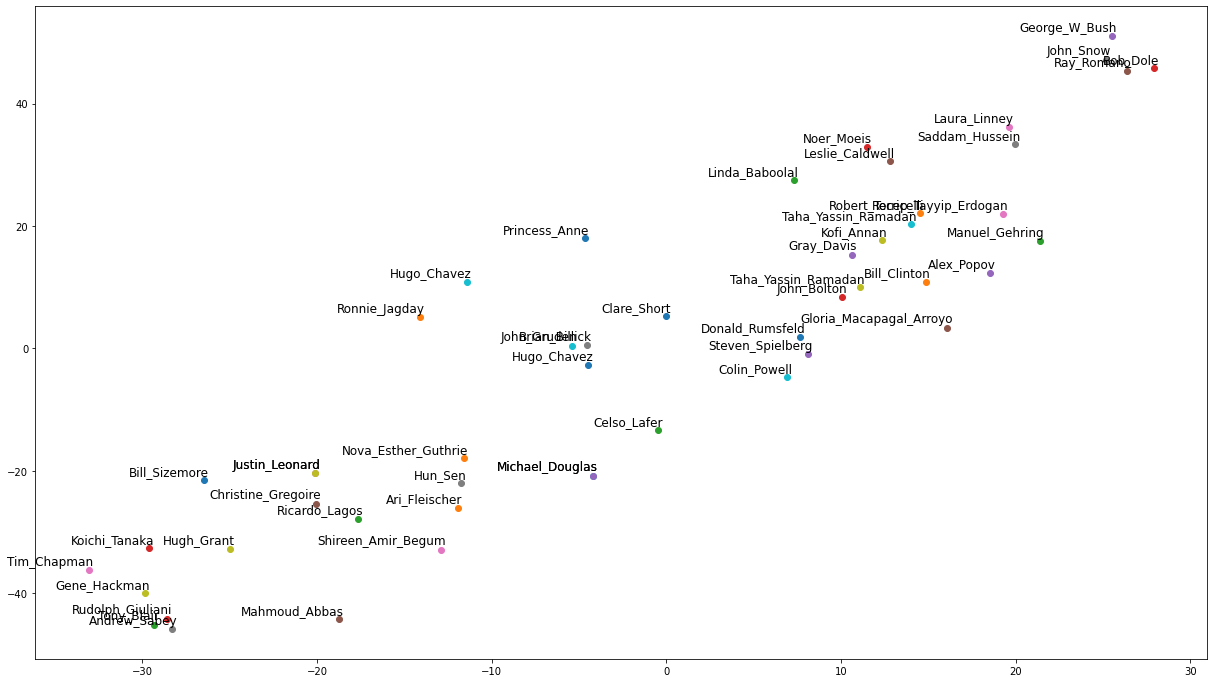

In [13]:
draw_embeddings(test_embs_2D, labels_for_viz)

## Вычисление расстояний между эмбеддингами

In [14]:
Renee_Zellweger_emb = []
Renee_Zellweger_pic = []
Princess_Caroline_emb = []
Princess_Caroline_pic = []
for i, person in enumerate(test_labels):
    if str(person, 'utf-8') == 'Renee_Zellweger':
        Renee_Zellweger_emb.append(test_embs[i])
        Renee_Zellweger_pic.append(test_images[i])        
    if str(person, 'utf-8') == 'Princess_Caroline':
        Princess_Caroline_emb.append(test_embs[i])    
        Princess_Caroline_pic.append(test_images[i])

(-0.5, 127.5, 127.5, -0.5)

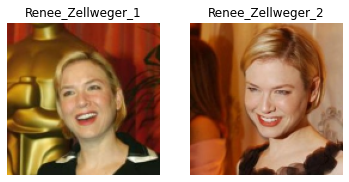

In [15]:
plt.figure()
plt.subplot(1, 2, 1)
plt.title('Renee_Zellweger_1')
plt.imshow(Renee_Zellweger_pic[2])
plt.axis('off')
plt.subplot(1, 2, 2)

plt.title('Renee_Zellweger_2')
plt.imshow(Renee_Zellweger_pic[3])
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

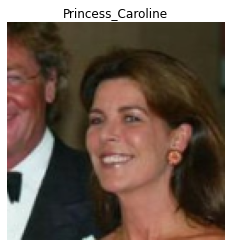

In [16]:
plt.figure()
plt.title('Princess_Caroline')
plt.imshow(Princess_Caroline_pic[0])
plt.axis('off')

In [19]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5


emb1 = Renee_Zellweger_emb[2]
emb2 = Renee_Zellweger_emb[3]

emb3 = Princess_Caroline_emb[0]

print('Renee_Zellweger1 <-> Renee_Zellweger2: ', diff(emb1, emb2))
print('Renee_Zellweger2 <-> Renee_Zellweger1: ', diff(emb2, emb3))
print('Renee_Zellweger1 <-> Princess_Caroline1: ', diff(emb1, emb3))

Renee_Zellweger1 <-> Renee_Zellweger2:  15.83211365402315
Renee_Zellweger2 <-> Renee_Zellweger1:  29.724324406549282
Renee_Zellweger1 <-> Princess_Caroline1:  21.6060037251838
